# Assignment 5

In this assignment, you will create a static and an interactive map in Python.

Scores on this exercise are out of 20 points.
Read a few useful additional hints about what to consider when creating maps from this post.

Consider looking for some interesting datasets from various Global or Estonian data portals:

https://kodu.ut.ee/~kmoch/posts/geodata-portals/


Consider the design - classifications, colors and colormaps, resolution, legend) ... and the story - which datasets/layers together make an interesting map to present.

Use your imagination, do some additional calculations and apply the analysis methods you have learned during the course to new datasets that you find online (or from your other work/study projects). Consider also a form of spatial analysis, such as spatial relationships (intersects, contains ...) between data layers, combine with raster data or similar. For your workflow you should use at least 3 different datasets:

For example (you must apply at 2-3 spatial analyses processing  steps):

- a polygon layer, a raster layer and a points layer. You could then summarize the raster into the polygons and then an additional spatial analysis for the points data in relation to some of the polygons (e.g. rainfall raster, countries and highlight cities that are located in very dry countries)

- a polygon layer, a lines layer and a raster layer. Use the raster as a background (for spatial context) and then select polygons based on the linestrings that interact (e.g. intersect) with polygons (e.g. a river that crosses several countries and raster landuse or elevation)

But notice that an important goal here is that you try to do the visualizations as best as you can, too, it needs to look good and should make sense.

Submit your maps (png, html) and source code (.ipynb)` to Moodle and make sure to provide the download links for the data used!



Problem 1: Visualize a static map with multiple layers on it (10 points)
Find interesting datasets and mix them in order and create an interesting, good and beautiful STATIC map.



Problem 2: Visualize an interactive map (10 points)
You may reuse the datasets from the static maps assignment from Problem 1 above. This time create an interesting, good and beautiful INTERACTIVE map. Use either Bokeh or Folium.


You can add the data if it's small (less than 10 MB) and provide the download links for the data used (This is mandatory and worth 1 point each)!

Submit your maps (png, html) and source code ( .ipynb)` to Moodle. Consider zipping your HTML file if it is too big.



# Loading modules

In [1]:
# Import necessary geometric objects from shapely module

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import MultiPoint, MultiLineString
 
import shapely.speedups
shapely.speedups.enable()

import fiona
from fiona.crs import from_epsg # package to deal with coordinate reference systems

import os

import rasterio
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Loading data

The data has been added to two locations. The meta data file, this Jupyter notebook and the resulting maps were added to a github repository. The data that exceeded the size for github has been added to UT own cloud. Both links are provided follows

- Github repository [link](https://github.com/ayeshpiyara/Assignment_geopython2022)

- UT Owncloud [link](https://owncloud.ut.ee/owncloud/s/7HqMfYz2B2WrTpd)

## Meta data

The meta data is from a project I am currently working on. The experiment involved analysing soil samples extracted from various experimental and reference sites in dry calcarious (alvar) grass lands in western Estonia. The present work is attempted to study the sampling sites and their positions recorded during sampling process to suplement the research being done.

### Loading meta data

In [2]:
meta_data = pd.read_excel('Data/metadata_editted_clean_ayesh.xlsx')

In [3]:
meta_data

sample_code      site treatment    region reference          x          y
0         ARU-A   Aruküla    avatud   HIIUMAA       NaN  22.983607  58.863851
1         ARU-B   Aruküla  kadastik   HIIUMAA       NaN  22.983625  58.863163
2         ARU-C   Aruküla      mets   HIIUMAA       NaN  22.985934  58.863415
3     ARU-SAR-K   Aruküla  kontroll   HIIUMAA       NaN  23.004313  58.857315
4        ASV1-A     Asva1    avatud  SAAREMAA       NaN  23.070882  58.437078
..          ...       ...       ...       ...       ...        ...        ...
126      VOI3-B  Võiküla3  kadastik      MUHU       NaN  23.350066  58.536630
127       VOR-A    Võrsna    avatud  SAAREMAA       NaN  22.738100  58.384704
128       VOR-B    Võrsna  kadastik  SAAREMAA       NaN  22.737372  58.382991
129       VOR-C    Võrsna      mets  SAAREMAA       NaN  22.740779  58.384282
130       VOR-K    Võrsna  kontroll  SAAREMAA       NaN  22.744042  58.389345

[131 rows x 7 columns]

In [4]:
# Changing the treatment names to English 

meta_data['treatment'] = meta_data['treatment'].replace({'avatud':'Open',
                                                         'kadastik':'Scrub',
                                                         'mets':'Forest',
                                                         'kontroll':'Control'})

In [5]:
meta_data

sample_code      site treatment    region reference          x          y
0         ARU-A   Aruküla      Open   HIIUMAA       NaN  22.983607  58.863851
1         ARU-B   Aruküla     Scrub   HIIUMAA       NaN  22.983625  58.863163
2         ARU-C   Aruküla    Forest   HIIUMAA       NaN  22.985934  58.863415
3     ARU-SAR-K   Aruküla   Control   HIIUMAA       NaN  23.004313  58.857315
4        ASV1-A     Asva1      Open  SAAREMAA       NaN  23.070882  58.437078
..          ...       ...       ...       ...       ...        ...        ...
126      VOI3-B  Võiküla3     Scrub      MUHU       NaN  23.350066  58.536630
127       VOR-A    Võrsna      Open  SAAREMAA       NaN  22.738100  58.384704
128       VOR-B    Võrsna     Scrub  SAAREMAA       NaN  22.737372  58.382991
129       VOR-C    Võrsna    Forest  SAAREMAA       NaN  22.740779  58.384282
130       VOR-K    Võrsna   Control  SAAREMAA       NaN  22.744042  58.389345

[131 rows x 7 columns]

### Save the meta data as a shape file

In [6]:
meta_data_gdf = gpd.GeoDataFrame(meta_data,
                                 geometry=gpd.points_from_xy(meta_data.x, meta_data.y),
                                 crs = from_epsg(4326))

C:\Users\ayesh86\Miniconda3\envs\geopython2022\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [7]:
# Determine outputpath
result_folder = "Data/Meta_data"

# Create a new folder called 'Results' (if does not exist) to that folder using os.makedirs() function
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

In [8]:
# Output path
outfp = "Data/Meta_data/meta_data.shp"

# Save to disk
meta_data_gdf.to_file(outfp)

C:\Users\ayesh86\AppData\Local\Temp\ipykernel_16012\957568942.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  meta_data_gdf.to_file(outfp)


### Analysing the meta data file

In [9]:
# Set filepath 
sites_fp = "Data/Meta_data/meta_data.shp"

# Read file using gpd.read_file()
sites = gpd.read_file(sites_fp)

In [10]:
display(sites.head(5))

sample_cod     site treatment    region reference          x          y  \
0      ARU-A  Aruküla      Open   HIIUMAA      None  22.983607  58.863851   
1      ARU-B  Aruküla     Scrub   HIIUMAA      None  22.983625  58.863163   
2      ARU-C  Aruküla    Forest   HIIUMAA      None  22.985934  58.863415   
3  ARU-SAR-K  Aruküla   Control   HIIUMAA      None  23.004313  58.857315   
4     ASV1-A    Asva1      Open  SAAREMAA      None  23.070882  58.437078   

                    geometry  
0  POINT (22.98361 58.86385)  
1  POINT (22.98362 58.86316)  
2  POINT (22.98593 58.86342)  
3  POINT (23.00431 58.85731)  
4  POINT (23.07088 58.43708)

In [11]:
sites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Changing the CRS to be used down the line
sites_3301 = sites.to_crs(3301)

In [13]:
sites.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   sample_cod  131 non-null    object  
 1   site        131 non-null    object  
 2   treatment   131 non-null    object  
 3   region      131 non-null    object  
 4   reference   21 non-null     object  
 5   x           131 non-null    float64 
 6   y           131 non-null    float64 
 7   geometry    131 non-null    geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 8.3+ KB


<AxesSubplot: >

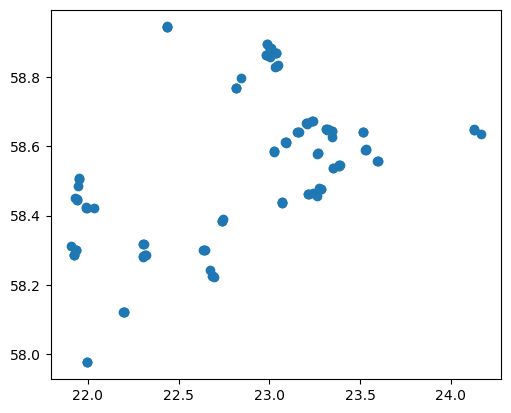

In [14]:
sites.plot()

#### Plot on a map to confirm 

Download data from Natural Earth

- countries: https://www.naturalearthdata.com/downloads/50m-cultural-vectors/50m-admin-0-countries/

In [15]:
# Set filepath
countries_fp = "Data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

# Read file using gpd.read_file()
countries = gpd.read_file(countries_fp)

In [16]:
countries.head(2)

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0  Admin-0 country          1          3   Zimbabwe    ZWE         0      2   
1  Admin-0 country          1          3     Zambia    ZMB         0      2   

                TYPE TLC     ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL  \
0  Sovereign country   1  Zimbabwe  ...      None       None      None   
1  Sovereign country   1    Zambia  ...      None       None      None   

  FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0      None       None      None      None       None      None   
1      None       None      None      None       None      None   

                                            geometry  
0  POLYGON ((31.28789 -22.40205, 31.19727 -22.344...  
1  POLYGON ((30.39609 -15.64307, 30.25068 -15.643...  

[2 rows x 169 columns]

In [17]:
# Checking the coordinate reference systems prior to analysis
display(countries.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
print(countries['NAME'].unique())

['Zimbabwe' 'Zambia' 'Yemen' 'Vietnam' 'Venezuela' 'Vatican' 'Vanuatu'
 'Uzbekistan' 'Uruguay' 'Micronesia' 'Marshall Is.' 'N. Mariana Is.'
 'U.S. Virgin Is.' 'Guam' 'American Samoa' 'Puerto Rico'
 'United States of America' 'S. Geo. and the Is.' 'Br. Indian Ocean Ter.'
 'Saint Helena' 'Pitcairn Is.' 'Anguilla' 'Falkland Is.' 'Cayman Is.'
 'Bermuda' 'British Virgin Is.' 'Turks and Caicos Is.' 'Montserrat'
 'Jersey' 'Guernsey' 'Isle of Man' 'United Kingdom' 'United Arab Emirates'
 'Ukraine' 'Uganda' 'Turkmenistan' 'Turkey' 'Tunisia'
 'Trinidad and Tobago' 'Tonga' 'Togo' 'Timor-Leste' 'Thailand' 'Tanzania'
 'Tajikistan' 'Taiwan' 'Syria' 'Switzerland' 'Sweden' 'eSwatini'
 'Suriname' 'S. Sudan' 'Sudan' 'Sri Lanka' 'Spain' 'South Korea'
 'South Africa' 'Somalia' 'Somaliland' 'Solomon Is.' 'Slovakia' 'Slovenia'
 'Singapore' 'Sierra Leone' 'Seychelles' 'Serbia' 'Senegal' 'Saudi Arabia'
 'São Tomé and Principe' 'San Marino' 'Samoa' 'St. Vin. and Gren.'
 'Saint Lucia' 'St. Kitts and Nevis' 'Rwa

In [19]:
countries.loc[countries['NAME'] == "Estonia"]

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
172  Admin-0 country          1          6    Estonia    EST         0      2   

                  TYPE TLC    ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL  \
172  Sovereign country   1  Estonia  ...      None       None      None   

    FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
172      None       None      None      None       None      None   

                                              geometry  
172  MULTIPOLYGON (((27.35195 57.52812, 27.32656 57...  

[1 rows x 169 columns]

In [20]:
est = countries.loc[countries['NAME'] == "Estonia"]

In [21]:
# Check the crs
sites.crs == est.crs

True

<AxesSubplot: >

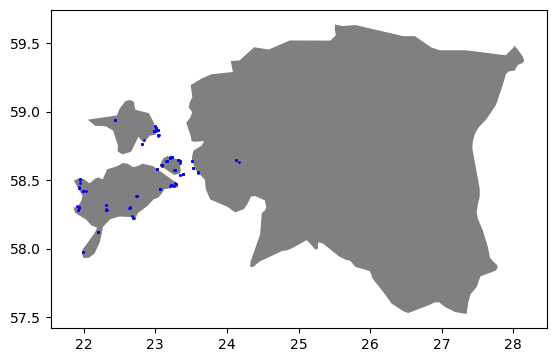

In [22]:
# Plot to check
fig, ax = plt.subplots()

est.plot(ax = ax, facecolor = 'gray')
sites.plot(ax = ax, facecolor = 'blue', markersize = 1)

### Subset the sites to Experimental and Reference sites and save them seperately

In [23]:
sites.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   sample_cod  131 non-null    object  
 1   site        131 non-null    object  
 2   treatment   131 non-null    object  
 3   region      131 non-null    object  
 4   reference   21 non-null     object  
 5   x           131 non-null    float64 
 6   y           131 non-null    float64 
 7   geometry    131 non-null    geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 8.3+ KB


In [24]:
sites.columns

Index(['sample_cod', 'site', 'treatment', 'region', 'reference', 'x', 'y',
       'geometry'],
      dtype='object')

In [25]:
print(sites['reference'].unique())

[None 'REFERENCE']


In [26]:
# Reference sites

sites_ref = sites[sites['reference'] == 'REFERENCE']

In [27]:
sites_ref.head(2)

sample_cod  site treatment    region  reference          x          y  \
8      ATL-A  Atla      Open  SAAREMAA  REFERENCE  21.935135  58.300916   
9      ATL-B  Atla     Scrub  SAAREMAA  REFERENCE  21.935655  58.301682   

                    geometry  
8  POINT (21.93513 58.30092)  
9  POINT (21.93566 58.30168)

In [28]:
# Experimental sites

sites_exp = sites[sites['reference'] != 'REFERENCE']

In [29]:
sites_exp.head(2)

sample_cod     site treatment   region reference          x          y  \
0      ARU-A  Aruküla      Open  HIIUMAA      None  22.983607  58.863851   
1      ARU-B  Aruküla     Scrub  HIIUMAA      None  22.983625  58.863163   

                    geometry  
0  POINT (22.98361 58.86385)  
1  POINT (22.98362 58.86316)

In [30]:
# Create a output path for the data
out_file_path = "Data/Meta_data/sites_ref.shp"

# Write Shapefile
sites_ref.to_file(out_file_path)

In [31]:
# Create a output path for the data
out_file_path = "Data/Meta_data/sites_exp.shp"

# Write Shapefile
sites_exp.to_file(out_file_path)

In [32]:
sites_ref_3301 = sites_ref.to_crs(3301)

In [33]:
# Set filepath 
sites_ref_fp = "Data/Meta_data/sites_ref.shp"

# Read file using gpd.read_file()
sites_ref = gpd.read_file(sites_ref_fp)

In [34]:
# Set filepath 
sites_exp_fp = "Data/Meta_data/sites_exp.shp"

# Read file using gpd.read_file()
sites_exp = gpd.read_file(sites_exp_fp)

In [35]:
sites_exp_3301 = sites_exp.to_crs(3301)

### Estonian Landboard Geoportal

https://geoportaal.maaamet.ee/

Counties, Municipalities and Settlements

https://geoportaal.maaamet.ee/eng/Spatial-Data/Administrative-and-Settlement-Division-p312.html

Counties - maakond_shp

In [36]:
# Set filepath 
counties_fp = "Data/maakond_shp/maakond_20230104.shp"

# Read data
counties = gpd.read_file(counties_fp)

In [37]:
counties.head(2)

MNIMI MKOOD                                           geometry
0     Saare maakond  0074  MULTIPOLYGON (((455191.283 6404986.597, 455187...
1  Viljandi maakond  0084  MULTIPOLYGON (((621049.180 6453125.120, 621052...

In [38]:
# Changing the CRS to be used down the line
counties_4326 = counties.to_crs(4326)

Municipalities - omavalitsus_shp

In [39]:
# Set filepath 
municipalities_fp = "Data/omavalitsus_shp/omavalitsus_20230104.shp"

# Read data
municipalities = gpd.read_file(municipalities_fp)

In [40]:
municipalities.head(2)

ONIMI OKOOD          MNIMI MKOOD TYYP  \
0  Ruhnu vald  0689  Saare maakond  0074    1   
1   Muhu vald  0478  Saare maakond  0074    1   

                                            geometry  
0  MULTIPOLYGON (((455191.283 6404986.597, 455187...  
1  MULTIPOLYGON (((463402.330 6483159.035, 463412...

Settlements - asustusyksus_shp

In [41]:
# Set filepath 
settlements_fp = "Data/asustusyksus_shp/asustusyksus_20230104.shp"

# Read data
settlements = gpd.read_file(settlements_fp)

In [42]:
settlements.head(2)

ANIMI AKOOD TYYP           ONIMI OKOOD  \
0  Väikeheinamaa küla / Lillängin  9619    8     Viimsi vald  0890   
1                  Saviranna küla  7498    8  Jõelähtme vald  0245   

           MNIMI MKOOD                                           geometry  
0  Harju maakond  0037  MULTIPOLYGON (((527973.102 6601583.615, 527971...  
1  Harju maakond  0037  POLYGON ((558032.517 6596790.149, 558033.896 6...

Estonian Soil Map

https://geoportaal.maaamet.ee/eng/Spatial-Data/Estonian-Soil-Map-p316.html

Soil map - Mullakaart_SHP

I tried to use soil data for the analysis but the data was to large to be handled on my machine and had to drop the attempt

In [43]:
# Set filepath 
# soil_map_fp = "Data/Mullakaart_SHP/Mullakaart.shp"

# Read data
# soil_map = gpd.read_file(soil_map_fp)

In [44]:
# soil_map.head(2)

In [45]:
# soil_map.plot()

In [46]:
# soil_map.crs

In [47]:
# soil_map_4326 = soil_map.to_crs(4326)

### Copernicus landuse data (CORINE Land Cover)

https://land.copernicus.eu/

In [48]:
# Read data
clc_2020_fp = 'Data/u2006_clc2000_v2020_20u1_raster100m/DATA/U2006_CLC2000_V2020_20u1.tif'

In [49]:
with rasterio.open(clc_2020_fp) as src:
    print(src.profile)
    print(src.crs)

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 65000, 'height': 46000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]'), 'transform': Affine(100.0, 0.0, 900000.0,
       0.0, -100.0, 5500000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 19

In [50]:
counties.crs

<Derived Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [51]:
counties_3035 = counties.to_crs(3035)

Extracting the region for Estonia

In [52]:
counties_3035.head(2)

MNIMI MKOOD                                           geometry
0     Saare maakond  0074  MULTIPOLYGON (((5104828.346 3926591.878, 51048...
1  Viljandi maakond  0084  MULTIPOLYGON (((5257415.315 4006136.614, 52574...

In [53]:
with rasterio.open(clc_2020_fp) as src:
    clc_out_image, clc_out_transform = mask(dataset=src, shapes=counties_3035['geometry'], crop=True)
    clc_out_meta = src.meta.copy()

In [54]:
clc_out_transform 

Affine(100.0, 0.0, 5006700.0,
       0.0, -100.0, 4185800.0)

In [55]:
clc_out_meta.update({"driver": "GTiff",
                 "height": clc_out_image.shape[1],
                 "width": clc_out_image.shape[2],
                 "transform": clc_out_transform})

with rasterio.open("clc_2020_clipped.tif", "w", **clc_out_meta) as dest:
    dest.write(clc_out_image)

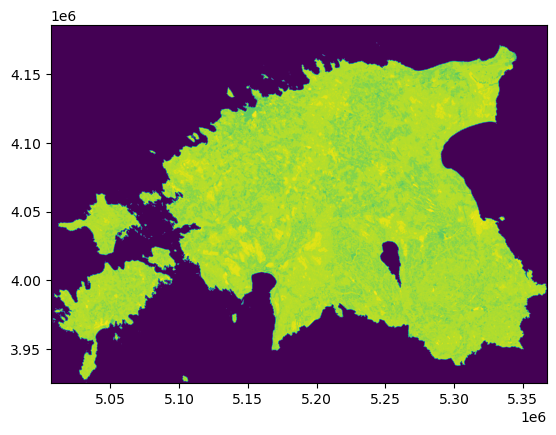

In [56]:
with rasterio.open("clc_2020_clipped.tif", "r") as clc_est:
    show(clc_est)

In [57]:
dst_crs = 'EPSG:3301'

with rasterio.open('clc_2020_clipped.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, 
                                                           dst_crs, 
                                                           src.width, 
                                                           src.height, 
                                                           *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('clc_2020_clipped_3301.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rasterio.band(src, i),
                      destination=rasterio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform, 
                      dst_crs=dst_crs, 
                      resampling=Resampling.nearest)

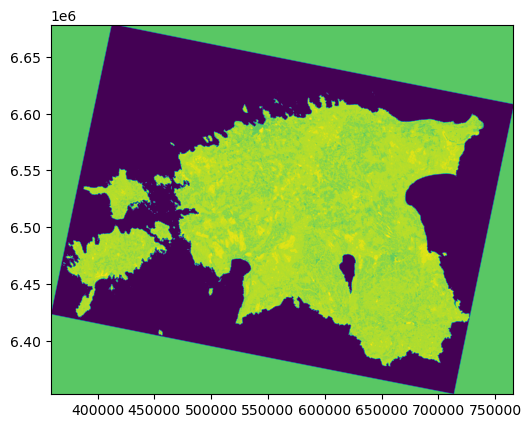

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 4086, 'height': 3267, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(99.56679873418949, 0.0, 358734.27226800355,
       0.0, -99.56679873418949, 6678217.0971970055), 'tiled': False, 'interleave': 'band'}

In [58]:
with rasterio.open('clc_2020_clipped_3301.tif', 'r') as clc_est:
    show(clc_est)
    display(clc_est.profile)

### Copernicus Climate Change Service data set

https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=form

Since sampling was done in 2019 studies were done using data files representing information in and around that time

The geopackage for this data was also to large to be handled on my laptop.

In [59]:
# gpkg_fp = "Data/u2006_clc2000_v2020_20u1_geoPackage/DATA/U2006_CLC2000_V2020_20u1.gpkg"

# fiona.listlayers(gpkg_fp)

I used the tif file for the studies 

In [60]:
# Read data
cci_2019_fp = 'Data/C3S-LC-L4-LCCS-Map-300m-P1Y-2019-v2.1.1.tif'

In [61]:
with rasterio.open(cci_2019_fp) as src:
    print(src.profile)
    print(src.crs)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 129600, 'height': 64800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002777777777778, 0.0, -180.0,
       0.0, -0.002777777777778, 90.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
EPSG:4326


In [62]:
counties.crs

<Derived Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Extracting the region for Estonia

In [63]:
counties_4326.head(2)

MNIMI MKOOD                                           geometry
0     Saare maakond  0074  MULTIPOLYGON (((23.24678 57.78452, 23.24671 57...
1  Viljandi maakond  0084  MULTIPOLYGON (((26.05909 58.20230, 26.05914 58...

In [64]:
with rasterio.open(cci_2019_fp) as src:
    cci_out_image, cci_out_transform = mask(dataset=src, shapes=counties_4326['geometry'], crop=True)
    cci_out_meta = src.meta.copy()

In [65]:
cci_out_transform 

Affine(0.002777777777778, 0.0, 21.76388888890503,
       0.0, -0.002777777777778, 59.82222222221981)

In [66]:
cci_out_meta.update({"driver": "GTiff",
                 "height": cci_out_image.shape[1],
                 "width": cci_out_image.shape[2],
                 "transform": cci_out_transform})

with rasterio.open("cci_2019_clipped.tif", "w", **cci_out_meta) as dest:
    dest.write(cci_out_image)

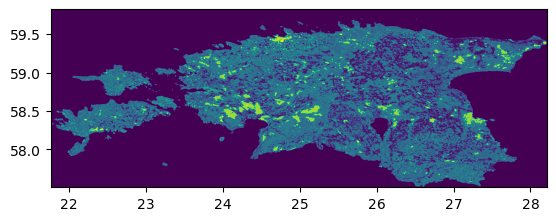

In [67]:
with rasterio.open("cci_2019_clipped.tif", "r") as cci_est:
    show(cci_est)

Reprojecting to Estonian system

In [68]:
dst_crs = 'EPSG:3301'

with rasterio.open('cci_2019_clipped.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, 
                                                           dst_crs, 
                                                           src.width, 
                                                           src.height, 
                                                           *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('cci_2019_clipped_3301.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rasterio.band(src, i),
                      destination=rasterio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform, 
                      dst_crs=dst_crs, 
                      resampling=Resampling.nearest)

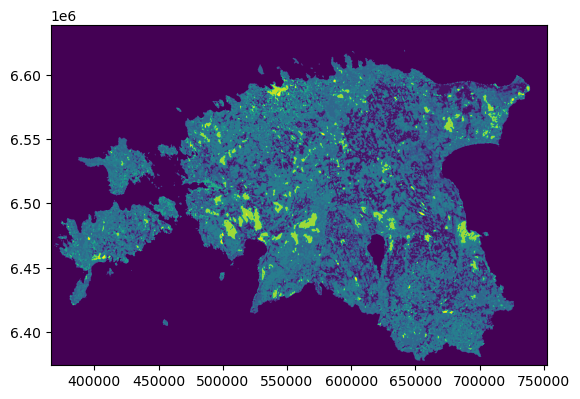

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2098, 'height': 1440, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(184.11597625652283, 0.0, 365971.61584457755,
       0.0, -184.11597625652283, 6639129.513003287), 'tiled': False, 'interleave': 'band'}

In [69]:
with rasterio.open('cci_2019_clipped_3301.tif', 'r') as cci_est:
    show(cci_est)
    display(cci_est.profile)

## Problem 1: 

Visualize a static map with multiple layers on it (10 points)
Find interesting datasets and mix them in order and create an interesting, good and beautiful STATIC map.

Selecting the counties of the sampling sites

In [70]:
sites_3301.crs == counties.crs

True

In [71]:
sites_ref_3301.crs == counties.crs

True

In [72]:
sites_exp_3301.crs == counties.crs

True

<AxesSubplot: >

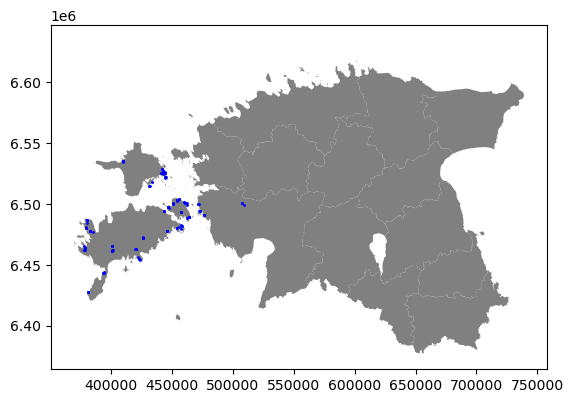

In [73]:
# Plot to check
fig, ax = plt.subplots()

counties.plot(ax = ax, facecolor = 'gray')
sites_3301.plot(ax = ax, facecolor = 'blue', markersize = 1)

### Creating polygon with the sites

In [74]:
poly = Polygon([ [p.x, p.y] for p in sites['geometry'].tolist() ]) 

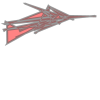

In [75]:
display(poly)

In [76]:
print(poly)

POLYGON ((22.983607 58.863851, 22.983625 58.863163, 22.985934 58.863415, 23.004313 58.857315, 23.070882 58.4370778, 23.0700346 58.437295, 23.070161 58.437657, 23.068081 58.438899, 21.935135 58.300916, 21.935655 58.301682, 21.936694 58.302054, 21.9252142 58.2871471, 21.9237174 58.2857311, 21.9230179 58.2853936, 21.9089 58.3132, 23.513742 58.641074, 23.51333 58.641331, 23.517104 58.640573, 23.0057263 58.8815983, 23.036216 58.867939, 23.0060814 58.8805968, 23.036068 58.868128, 23.0069487 58.8813131, 23.035971 58.867287, 23.0060027 58.8818197, 22.642026 58.30212, 22.641855 58.3007326, 22.633728 58.300492, 22.646013 58.30055, 23.215141 58.463435, 23.2110683 58.4617282, 23.2162724 58.4633303, 23.240038 58.465636, 23.2741531 58.4796122, 23.2830151 58.4767888, 23.2846242 58.4767887, 23.264865 58.456588, 22.814323 58.768253, 22.815398 58.768419, 22.817999 58.768231, 22.845831 58.795092, 23.091042 58.610773, 23.091061 58.611386, 23.0850341 58.613238, 23.092176 58.60825, 21.93925 58.446525, 21.94

In [77]:
# Getting bounds for extra information
poly_bbox = poly.bounds

In [78]:
poly_bbox

(21.9089, 57.976689, 24.163626, 58.9446446)

In [79]:
poly_gpd = gpd.GeoDataFrame()
poly_gpd.loc[0, 'label'] = 'sites polygon'
poly_gpd.loc[0,'geometry'] = poly

poly_gpd.crs = 4326

In [80]:
poly_gpd

label                                           geometry
0  sites polygon  POLYGON ((22.98361 58.86385, 22.98362 58.86316...

In [81]:
# Counties that is found intersecting the sites polygon
counties_sub = counties_4326[counties_4326.intersects(poly_gpd.loc[0, 'geometry'])]

counties_sub

MNIMI MKOOD                                           geometry
0   Saare maakond  0074  MULTIPOLYGON (((23.24678 57.78452, 23.24671 57...
2    Hiiu maakond  0039  MULTIPOLYGON (((22.58669 58.68861, 22.58663 58...
12  Pärnu maakond  0068  MULTIPOLYGON (((24.35443 57.87700, 24.35434 57...

<AxesSubplot: >

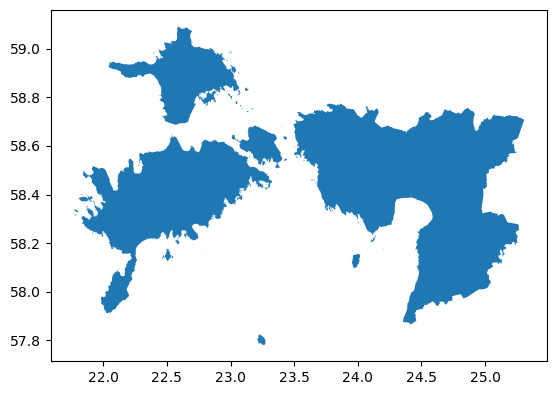

In [82]:
counties_sub.plot()

In [83]:
counties_sub.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [84]:
counties_sub_3301 = counties_sub.to_crs(3301)

### Clipping the land cover tif file to selected counties

In [85]:
clc_2020_clip_fp = 'clc_2020_clipped_3301.tif'

In [86]:
with rasterio.open(clc_2020_clip_fp) as src:
    print(src.profile)
    print(src.crs)

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 4086, 'height': 3267, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(99.56679873418949, 0.0, 358734.27226800355,
       0.0, -99.56679873418949, 6678217.0971970055), 'tiled': False, 'interleave': 'band'}
EPSG:3301


In [87]:
with rasterio.open(clc_2020_clip_fp) as src:
    clc_sub_out_image, clc_sub_out_transform = mask(dataset=src, shapes=counties_sub_3301['geometry'], crop=True)
    clc_sub_out_meta = src.meta.copy()

In [88]:
clc_sub_out_meta.update({"driver": "GTiff",
                 "height": clc_sub_out_image.shape[1],
                 "width": clc_sub_out_image.shape[2],
                 "transform": clc_sub_out_transform})

with rasterio.open("clc_sub_2020_clipped.tif", "w", **clc_sub_out_meta) as dest:
    dest.write(clc_sub_out_image)

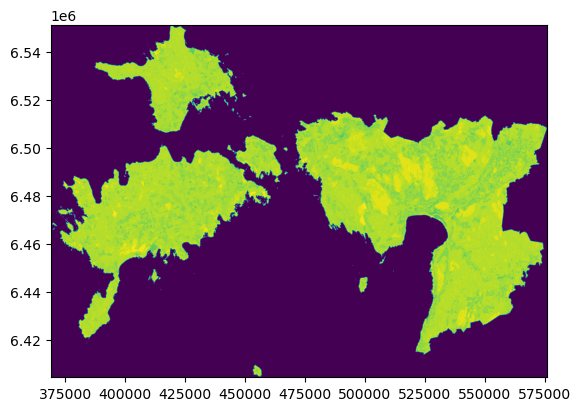

In [89]:
with rasterio.open("clc_sub_2020_clipped.tif", "r") as clc_sub_est:
    show(clc_sub_est)

### Clipping the land use land cover tif file to selected counties

In [90]:
cci_2019_clip_fp = 'cci_2019_clipped_3301.tif'

In [91]:
with rasterio.open(cci_2019_clip_fp) as src:
    print(src.profile)
    print(src.crs)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2098, 'height': 1440, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(184.11597625652283, 0.0, 365971.61584457755,
       0.0, -184.11597625652283, 6639129.513003287), 'tiled': False, 'interleave': 'band'}
EPSG:3301


In [92]:
with rasterio.open(cci_2019_clip_fp) as src:
    cci_sub_out_image, cci_sub_out_transform = mask(dataset=src, shapes=counties_sub_3301['geometry'], crop=True)
    cci_sub_out_meta = src.meta.copy()

In [93]:
cci_sub_out_meta.update({"driver": "GTiff",
                 "height": cci_sub_out_image.shape[1],
                 "width": cci_sub_out_image.shape[2],
                 "transform": cci_sub_out_transform})

with rasterio.open("cci_sub_2019_clipped.tif", "w", **cci_sub_out_meta) as dest:
    dest.write(cci_sub_out_image)

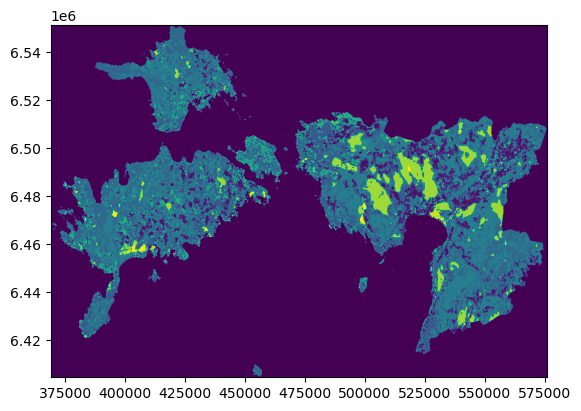

In [94]:
with rasterio.open("cci_sub_2019_clipped.tif", "r") as cci_sub_est:
    show(cci_sub_est)

In [95]:
cci_sub_2019_clip_fp = "cci_sub_2019_clipped.tif"

In [96]:
with rasterio.open(cci_sub_2019_clip_fp) as src:
    print(src.profile)
    print(src.crs)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1124, 'height': 799, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(184.11597625652283, 0.0, 368917.4714646819,
       0.0, -184.11597625652283, 6551490.3083051825), 'tiled': False, 'interleave': 'band'}
EPSG:3301


### Plotting for the counties

In [97]:
cci_legend_path = 'Data/ESA_landcover_legend.csv'

cci_legend = pd.read_csv(cci_legend_path)

In [98]:
cci_legend.head(2)

Value  AGG_NAME  Value_AGG_w  Value_AGG               NAME    R    G    B
0      0   No Data            0          5            No Data    0    0    0
1     10  Cropland            3          3  Cropland, rainfed  255  255  100

In [99]:
cci_legend['Value_AGG_w'].unique()

array([0, 3, 2, 1, 4, 5, 6, 7], dtype=int64)

Unique value from raster

In [100]:
with rasterio.open('cci_sub_2019_clipped.tif', 'r') as cci_sub:
    band = cci_sub.read(1)
    uniq = np.unique(band)

print(uniq)

[  0  10  11  30  40  60  61  70  80  90 100 110 130 150 180 190 200 202
 210]


In [101]:
len(uniq)

19

Chaning RGB from hex or 0 to 256 compressed to 0 to 1

In [102]:
def to_mpl(c):
    mpl_c = 0 if c == 0 else c /255
    return mpl_c

In [103]:
def colour_from_row(row):
    r = to_mpl(row['R'])
    g = to_mpl(row['G'])
    b = to_mpl(row['B'])
    return(r, g, b)

cci_legend['mpl_rgb'] = cci_legend.apply(colour_from_row, axis = 1)

In [104]:
cci_legend.head(2)

Value  AGG_NAME  Value_AGG_w  Value_AGG               NAME    R    G    B  \
0      0   No Data            0          5            No Data    0    0    0   
1     10  Cropland            3          3  Cropland, rainfed  255  255  100   

                           mpl_rgb  
0                        (0, 0, 0)  
1  (1.0, 1.0, 0.39215686274509803)

In [105]:
uniq = list(uniq)

In [106]:
cci_legend_demo = cci_legend.loc[cci_legend['Value'].isin(uniq)]

cci_legend_demo.head(2)

Value  AGG_NAME  Value_AGG_w  Value_AGG               NAME    R    G    B  \
0      0   No Data            0          5            No Data    0    0    0   
1     10  Cropland            3          3  Cropland, rainfed  255  255  100   

                           mpl_rgb  
0                        (0, 0, 0)  
1  (1.0, 1.0, 0.39215686274509803)

In [107]:
colours = cci_legend_demo['mpl_rgb'].to_list()

labels = cci_legend_demo['NAME'].to_list()

In [108]:
nbr_cmap = ListedColormap(colours)

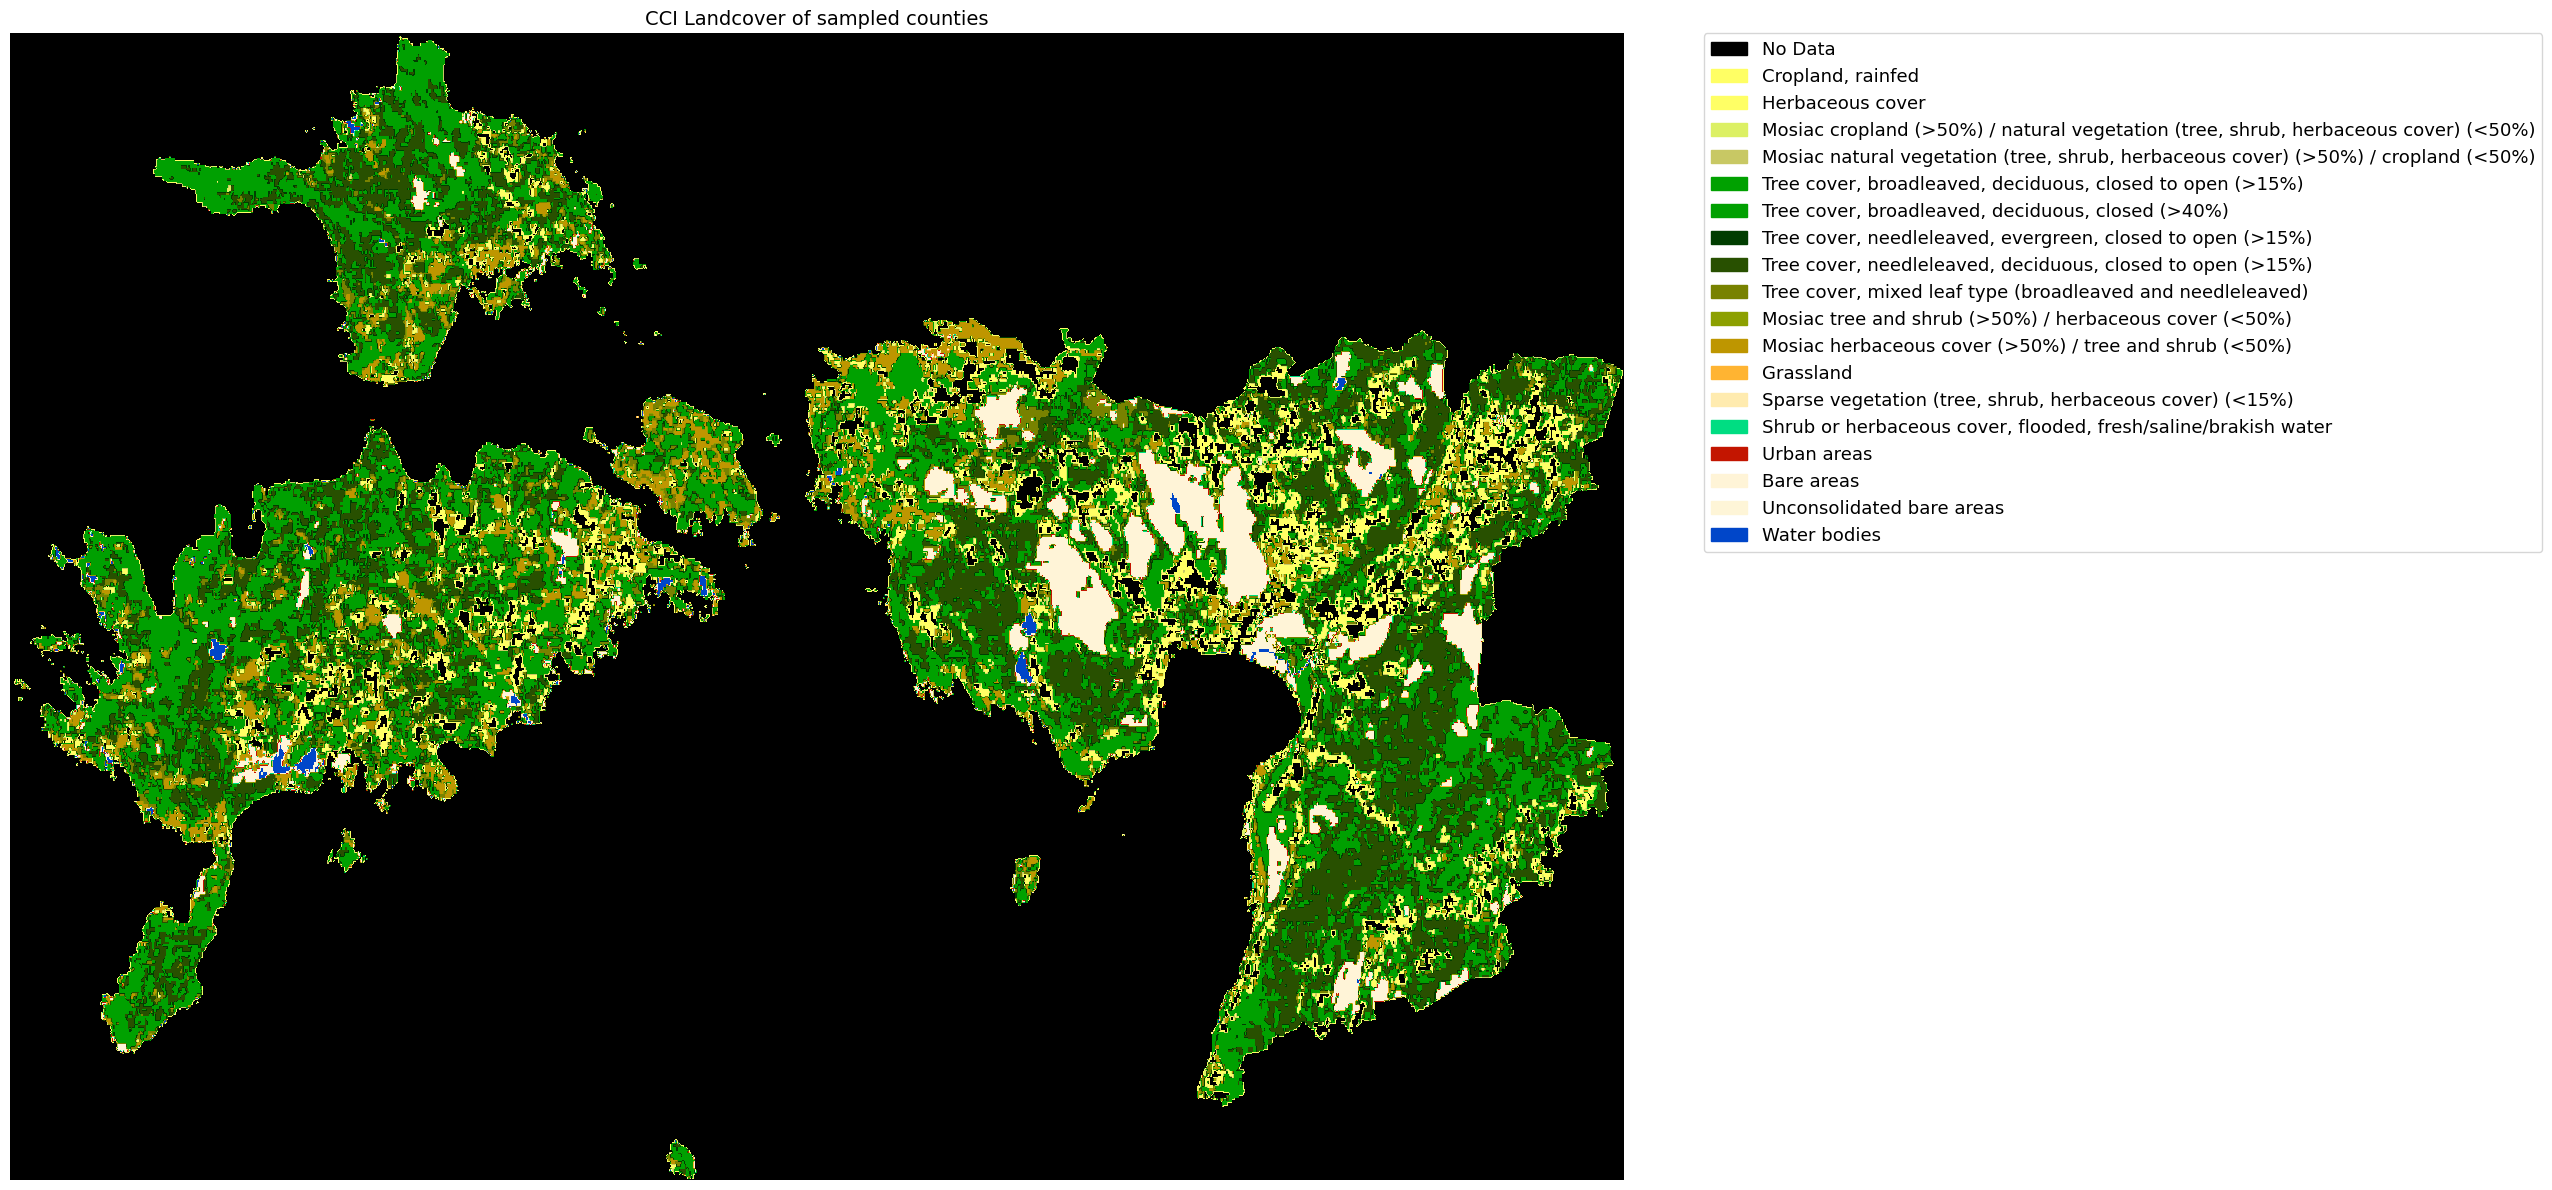

In [109]:
# Plot your data
fig, ax = plt.subplots(figsize=(32, 12))

im = ax.imshow(band, cmap=nbr_cmap)
ep.draw_legend(im_ax=im, classes=uniq, titles=labels)

ax.set_title("CCI Landcover of sampled counties", fontsize=14)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()

outfp = "static_map_1_ayesh.png"
plt.savefig(outfp, dpi=300)

Plotting the data points

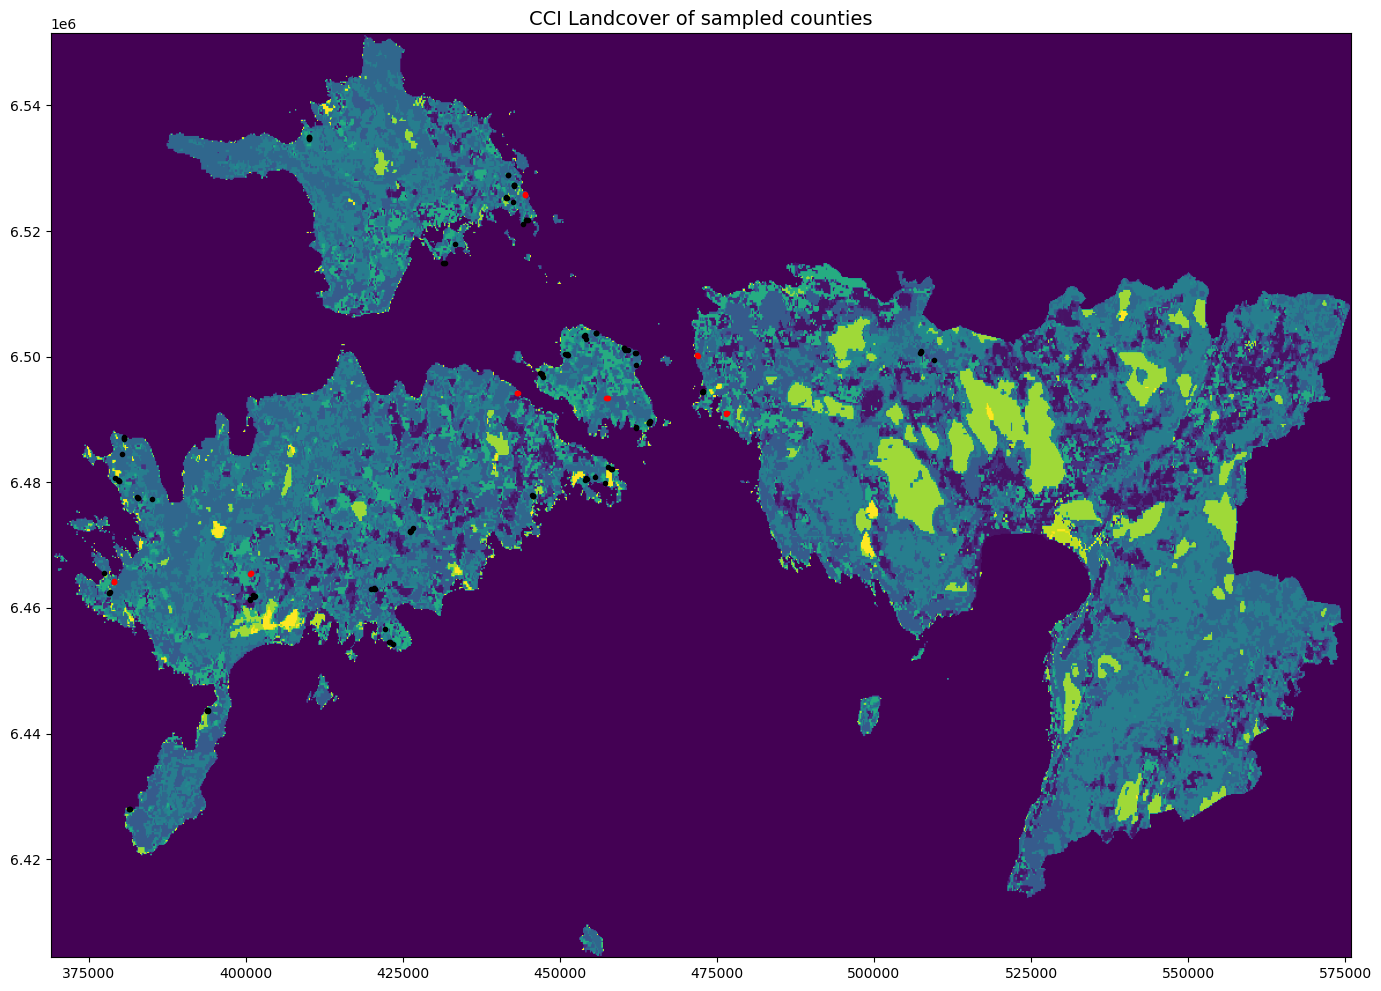

In [110]:
dataset = rasterio.open("cci_sub_2019_clipped.tif")

# Plot your data
fig, ax = plt.subplots(figsize=(32, 12))

show(dataset, ax=ax)

sites_exp_3301.plot(ax=ax, 
                    color="black", 
                    markersize=9.0)


sites_ref_3301.plot(ax=ax, 
                    color="red", 
                    markersize=9.0)

ax.set_title("CCI Landcover of sampled counties", fontsize=14)

plt.show()

dataset.close()

### Plotting for municipalities

In [111]:
municipalities.head(2)

ONIMI OKOOD          MNIMI MKOOD TYYP  \
0  Ruhnu vald  0689  Saare maakond  0074    1   
1   Muhu vald  0478  Saare maakond  0074    1   

                                            geometry  
0  MULTIPOLYGON (((455191.283 6404986.597, 455187...  
1  MULTIPOLYGON (((463402.330 6483159.035, 463412...

In [112]:
counties_sub_3301.head()

MNIMI MKOOD                                           geometry
0   Saare maakond  0074  MULTIPOLYGON (((455191.283 6404986.597, 455187...
2    Hiiu maakond  0039  MULTIPOLYGON (((418048.719 6506294.706, 418045...
12  Pärnu maakond  0068  MULTIPOLYGON (((521030.708 6415090.504, 521025...

In [113]:
filter_list = ['Saare maakond', 'Hiiu maakond', 'Pärnu maakond']
municipalities_sub = municipalities[municipalities.MNIMI.isin(filter_list)]

In [114]:
municipalities_sub

ONIMI OKOOD          MNIMI MKOOD TYYP  \
0            Ruhnu vald  0689  Saare maakond  0074    1   
1             Muhu vald  0478  Saare maakond  0074    1   
3         Saaremaa vald  0714  Saare maakond  0074    1   
4          Hiiumaa vald  0205   Hiiu maakond  0039    1   
5            Kihnu vald  0303  Pärnu maakond  0068    1   
12      Lääneranna vald  0430  Pärnu maakond  0068    1   
17            Tori vald  0809  Pärnu maakond  0068    1   
29          Saarde vald  0712  Pärnu maakond  0068    1   
32           Pärnu linn  0624  Pärnu maakond  0068    4   
33     Häädemeeste vald  0214  Pärnu maakond  0068    1   
36  Põhja-Pärnumaa vald  0638  Pärnu maakond  0068    1   

                                             geometry  
0   MULTIPOLYGON (((455191.283 6404986.597, 455187...  
1   MULTIPOLYGON (((463402.330 6483159.035, 463412...  
3   MULTIPOLYGON (((383803.204 6418122.756, 383801...  
4   MULTIPOLYGON (((418048.719 6506294.706, 418045...  
5   MULTIPOLYGON (((499612.239 6438932.390, 499610...  
12  MULTIPOLYGON (((488158.202 6465468.733, 488157...  
17  POLYGON ((524050.310 6482067.080, 524112.570 6...  
29  POLYGON ((534572.430 6448152.910, 534589.920 6...  
32  MULTIPOLYGON (((511558.535 6447969.366, 511555...  
33  MULTIPOLYGON (((521030.708 6415090.504, 521025...  
36  POLYGON ((515015.500 6499206.600, 515020.880 6...

<AxesSubplot: >

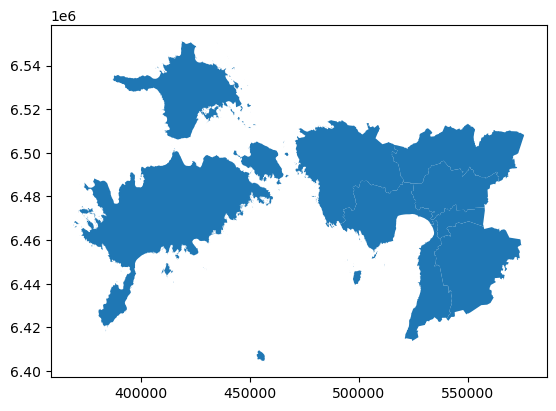

In [115]:
municipalities_sub.plot()

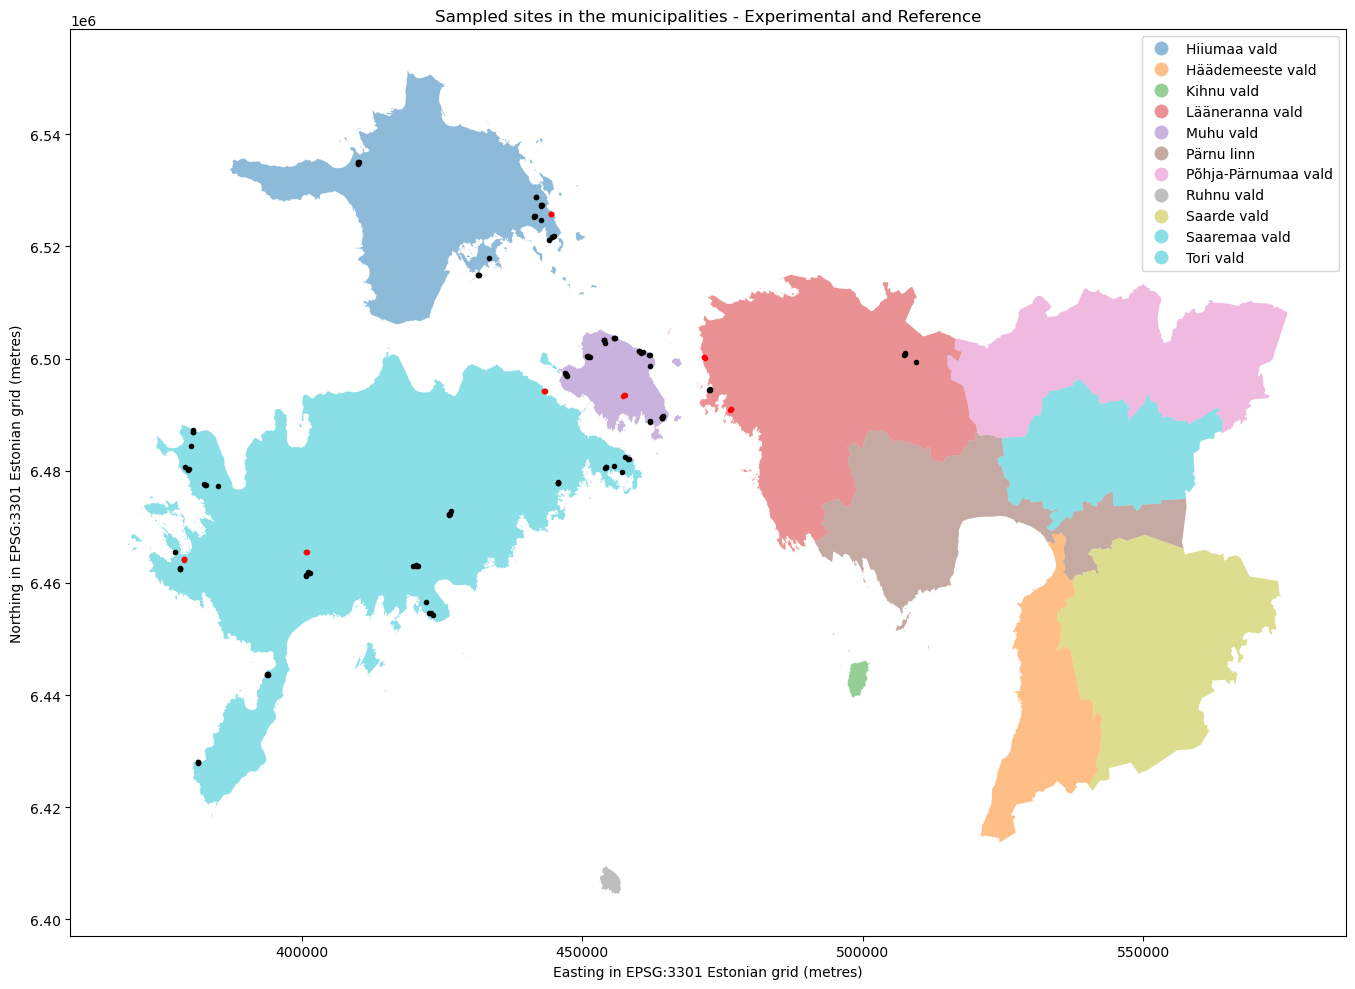

In [116]:
fig, ax = plt.subplots(figsize=(15, 10))

municipalities_sub.plot(column="ONIMI",
                        ax=ax,
                        linewidth=0.1,
                        alpha=0.5,
                        legend=True)


sites_exp_3301.plot(ax=ax, 
                    color="black", 
                    markersize=9.0)


sites_ref_3301.plot(ax=ax, 
                    color="red", 
                    markersize=9.0)

# Remove the empty white-space around the axes
plt.title("Sampled sites in the municipalities - Experimental and Reference")

ax.set_ylabel('Northing in EPSG:3301 Estonian grid (metres)')
ax.set_xlabel('Easting in EPSG:3301 Estonian grid (metres)')

plt.tight_layout()

outfp = "static_map_2_ayesh.png"
plt.savefig(outfp, dpi=300)

### Plotting for settlement units

In [117]:
settlements.head(2)

ANIMI AKOOD TYYP           ONIMI OKOOD  \
0  Väikeheinamaa küla / Lillängin  9619    8     Viimsi vald  0890   
1                  Saviranna küla  7498    8  Jõelähtme vald  0245   

           MNIMI MKOOD                                           geometry  
0  Harju maakond  0037  MULTIPOLYGON (((527973.102 6601583.615, 527971...  
1  Harju maakond  0037  POLYGON ((558032.517 6596790.149, 558033.896 6...

In [118]:
filter_list = ['Saare maakond', 'Hiiu maakond', 'Pärnu maakond']
settlements_sub = settlements[settlements.MNIMI.isin(filter_list)]

In [119]:
settlements_sub

ANIMI AKOOD TYYP            ONIMI OKOOD          MNIMI MKOOD  \
127        Linaküla  4381    8       Kihnu vald  0303  Pärnu maakond  0068   
128      Lemsi küla  4276    8       Kihnu vald  0303  Pärnu maakond  0068   
129      Sääre küla  7951    8       Kihnu vald  0303  Pärnu maakond  0068   
130      Rootsiküla  7089    8       Kihnu vald  0303  Pärnu maakond  0068   
132       Kapi küla  2695    8        Muhu vald  0478  Saare maakond  0074   
...             ...   ...  ...              ...   ...            ...   ...   
4539   Roobaka küla  7051    8    Saaremaa vald  0714  Saare maakond  0074   
4633     Kõera küla  3739    8  Lääneranna vald  0430  Pärnu maakond  0068   
4634   Ullaste küla  8663    8  Lääneranna vald  0430  Pärnu maakond  0068   
4681      Mõisaküla  5127    8  Lääneranna vald  0430  Pärnu maakond  0068   
4682  Salevere küla  7379    8  Lääneranna vald  0430  Pärnu maakond  0068   

                                               geometry  
127   MULTIPOLYGON (((497712.590 6444075.044, 497711...  
128   POLYGON ((500905.460 6445138.315, 500910.061 6...  
129   MULTIPOLYGON (((499135.591 6445714.865, 499132...  
130   MULTIPOLYGON (((499612.239 6438932.390, 499610...  
132   POLYGON ((454444.800 6499853.380, 454596.830 6...  
...                                                 ...  
4539  POLYGON ((429702.220 6490570.600, 429799.680 6...  
4633  MULTIPOLYGON (((474257.092 6507069.165, 474254...  
4634  MULTIPOLYGON (((475475.613 6507903.840, 475475...  
4681  POLYGON ((472988.000 6502781.960, 472995.390 6...  
4682  POLYGON ((476112.950 6503991.170, 476037.390 6...  

[1088 rows x 8 columns]

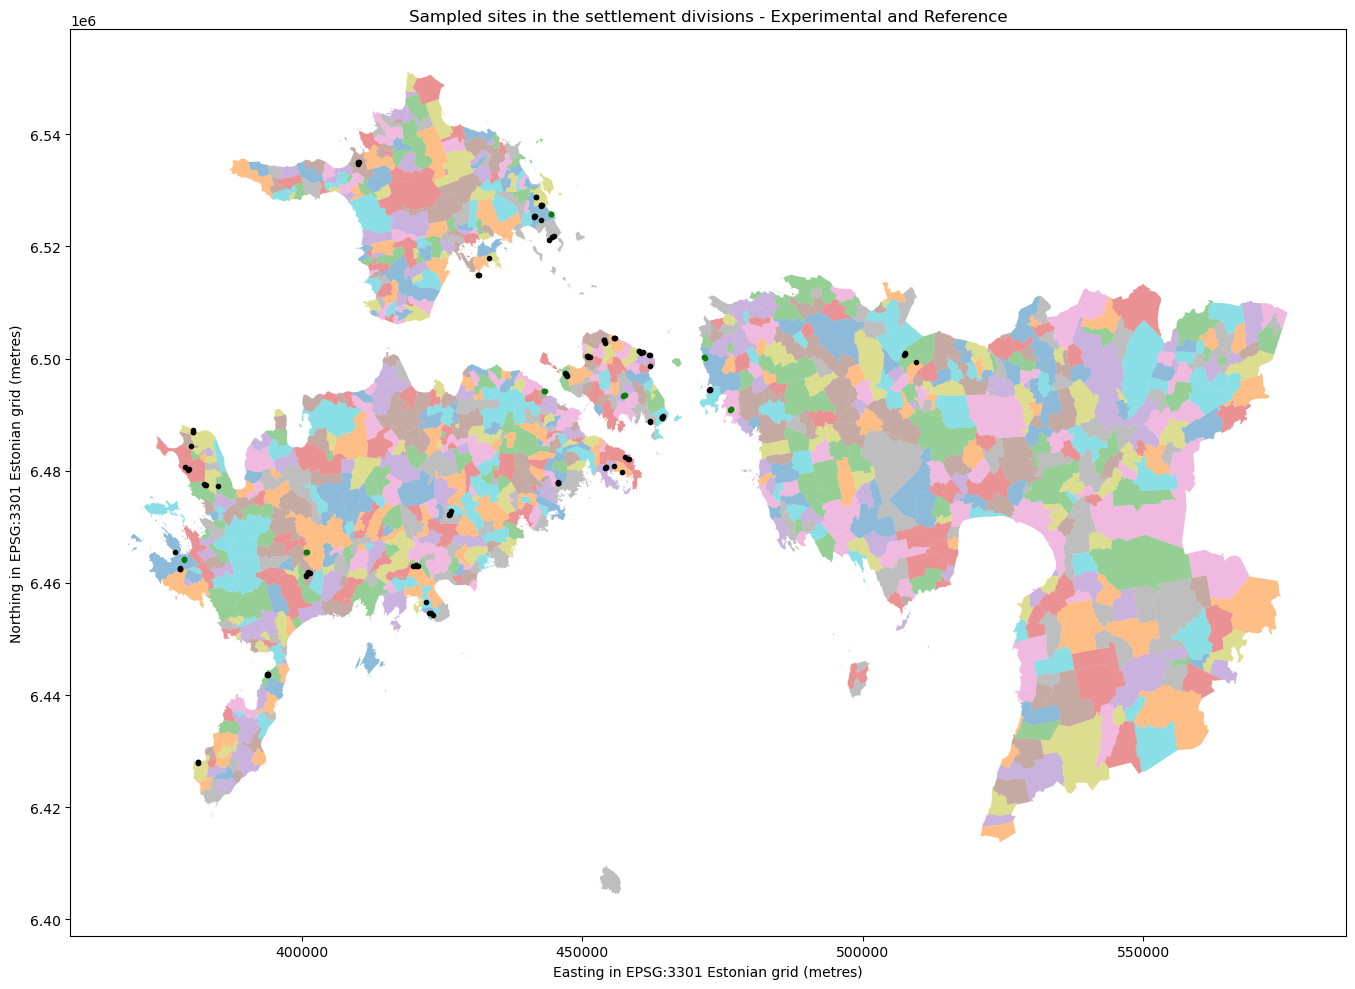

In [120]:
fig, ax = plt.subplots(figsize=(15, 10))

settlements_sub.plot(column="ANIMI",
                        ax=ax,
                        linewidth=0.1,
                        alpha=0.5,
                        legend=False)


sites_exp_3301.plot(ax=ax, 
                    color="black", 
                    markersize=9.0)


sites_ref_3301.plot(ax=ax, 
                    color="green", 
                    markersize=9.0)

# Remove the empty white-space around the axes
plt.title("Sampled sites in the settlement divisions - Experimental and Reference")

ax.set_ylabel('Northing in EPSG:3301 Estonian grid (metres)')
ax.set_xlabel('Easting in EPSG:3301 Estonian grid (metres)')

plt.tight_layout()

## Problem 2:

Visualize an interactive map (10 points)
You may reuse the datasets from the static maps assignment from Problem 1 above. This time create an interesting, good and beautiful INTERACTIVE map. Use either Bokeh or Folium.

I attempted to plot using Folium

### Folium

In [121]:
import folium

#### Locating the region for plotting

In [122]:
# Creating the centre of sites
p = MultiPoint([v for v in sites['geometry'].values]).centroid
print(p)  

POINT (22.862083905343507 58.53813417022899)


In [123]:
# Assigning coordinates of the centre
centre_lon = 22.862083905343507 
centre_lat = 58.53813417022899

In [124]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True, 
               prefer_canvas=True)

m

#### Plotting the experimental and reference sites

In [125]:
# Create a Geo-id which is needed by the Folium 
sites_ref['geoid'] = sites_ref.index.astype(str)
sites_exp['geoid'] = sites_exp.index.astype(str)

# Select data
sites_ref_f = sites_ref[['geoid', 'sample_cod', 'site', 'treatment', 'geometry']]
sites_exp_f = sites_exp[['geoid', 'sample_cod', 'site', 'treatment', 'geometry']]

# Convert the dataframe to geojson
sites_ref_jsontxt = sites_ref_f.to_json()
sites_exp_jsontxt = sites_exp_f.to_json()

In [126]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

folium.GeoJson(sites_ref_jsontxt).add_to(m)
folium.GeoJson(sites_exp_jsontxt).add_to(m)

# To display it in a Jupyter notebook, simply ask for the object representation
m

In [127]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

folium.GeoJson(sites_ref_jsontxt).add_to(m)
folium.GeoJson(sites_exp_jsontxt).add_to(m)

folium.LayerControl(collapsed=True).add_to(m)

# To display it in a Jupyter notebook, simply ask for the object representation
m

#### Plotting a more controlled plot 

In [128]:
sites_ref_f.head()

geoid sample_cod    site treatment                   geometry
0     0      ATL-A    Atla      Open  POINT (21.93513 58.30092)
1     1      ATL-B    Atla     Scrub  POINT (21.93566 58.30168)
2     2      ATL-C    Atla    Forest  POINT (21.93669 58.30205)
3     3      HAN-A  Hanila      Open  POINT (23.51374 58.64107)
4     4      HAN-B  Hanila     Scrub  POINT (23.51333 58.64133)

In [129]:
from shapely.geometry import Point

def getPoints(row, geom):
    """Returns coordinate pair tuples for the point ('lat', 'lon') of a Point geometry"""
    if isinstance(row[geom], Point):
        # we need lat lon order for the folium map!!!
        return (row[geom].y, row[geom].x)
    else:
        return ()

In [130]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# Calculate x and y coordinates of the line
sites_ref_f['points_tuple'] = sites_ref_f.apply(getPoints, geom='geometry', axis=1)
    
for idx, site_rf in sites_ref_f.iterrows():
    folium.CircleMarker(location=site_rf['points_tuple'], 
                        popup=site_rf['treatment'], 
                        color="blue", 
                        radius=2, 
                        opacity=0.9).add_to(m)
    
m

C:\Users\ayesh86\Miniconda3\envs\geopython2022\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [131]:
pd.options.mode.chained_assignment = None

# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# Calculate x and y coordinates of the line
sites_ref_f['points_tuple'] = sites_ref_f.apply(getPoints, geom='geometry', axis=1)

ref_site_layer = folium.FeatureGroup(name="reference site layer")
    
for idx, site_rf in sites_ref_f.iterrows():
    folium.CircleMarker(location=site_rf['points_tuple'], 
                        popup=site_rf['treatment'], 
                        color="blue", 
                        radius=2, 
                        opacity=0.9).add_to(ref_site_layer)
    
ref_site_layer.add_to(m)

folium.LayerControl(collapsed=True).add_to(m)
    
m

In [132]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# Calculate x and y coordinates of the line
sites_ref_f['points_tuple'] = sites_ref_f.apply(getPoints, geom='geometry', axis=1)

ref_site_layer = folium.FeatureGroup(name="reference site layer")
    
for idx, site_rf in sites_ref_f.iterrows():
    folium.CircleMarker(location=site_rf['points_tuple'], 
                        popup=site_rf['treatment'], 
                        color="blue", 
                        radius=2, 
                        opacity=0.9).add_to(ref_site_layer)

ref_site_layer.add_to(m)
    
# Calculate x and y coordinates of the line
sites_exp_f['points_tuple'] = sites_exp_f.apply(getPoints, geom='geometry', axis=1)

exp_site_layer = folium.FeatureGroup(name="experiment site layer")
    
for idx, site_ex in sites_exp_f.iterrows():
    folium.CircleMarker(location=site_ex['points_tuple'], 
                        popup=site_ex['treatment'], 
                        color="red", 
                        radius=2, 
                        opacity=0.9).add_to(exp_site_layer)

exp_site_layer.add_to(m)

folium.LayerControl(collapsed=True).add_to(m)

# To display it in a Jupyter notebook, simply ask for the object representation
m

#### Plotting data clusters

In [133]:
sites_ref_f.head(2)

geoid sample_cod  site treatment                   geometry  \
0     0      ATL-A  Atla      Open  POINT (21.93513 58.30092)   
1     1      ATL-B  Atla     Scrub  POINT (21.93566 58.30168)   

             points_tuple  
0  (58.300916, 21.935135)  
1  (58.301682, 21.935655)

In [134]:
from folium.plugins import MarkerCluster

# Get lat and lon of points
latlon_ref = [[tup[0], tup[1]] for tup in sites_ref_f['points_tuple'].tolist()]

# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# This function creates clusters for the points that are in the same area
# and then places them on the map
MarkerCluster(locations=latlon_ref, 
              fill_color='#2b8cbe', 
              name="sites_ref_f", 
              number_of_sides=6, 
              radius=6).add_to(m)

folium.LayerControl().add_to(m)

m

In [135]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# Get lat and lon of points
latlon_ref = [[tup[0], tup[1]] for tup in sites_ref_f['points_tuple'].tolist()]

# This function creates clusters for the points that are in the same area
# and then places them on the map
MarkerCluster(locations=latlon_ref, 
              fill_color='#2b8cbe', 
              name="sites_ref_f", 
              number_of_sides=6, 
              radius=6).add_to(m)

# Get lat and lon of points
latlon_exp = [[tup[0], tup[1]] for tup in sites_exp_f['points_tuple'].tolist()]

# This function creates clusters for the points that are in the same area
# and then places them on the map
MarkerCluster(locations=latlon_exp, 
              fill_color='#2b8cbe', 
              name="sites_exp_f", 
              number_of_sides=6, 
              radius=6).add_to(m)

folium.LayerControl().add_to(m)

m

In [136]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# This function creates clusters for the points that are in the same area
marker_cluster_ref = MarkerCluster(name="sites_ref_f", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_ref, ref_site in sites_ref_f.iterrows():
    folium.Marker(location=ref_site['points_tuple'],
                  popup=ref_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_ref)

marker_cluster_ref.add_to(m)
    
# This function creates clusters for the points that are in the same area
marker_cluster_exp = MarkerCluster(name="sites_exp_f", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_exp, exp_site in sites_exp_f.iterrows():
    folium.Marker(location=exp_site['points_tuple'],
                  popup=exp_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_exp)


marker_cluster_exp.add_to(m)

folium.LayerControl().add_to(m)

m

#### Plotting heat map

In [137]:
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)


random_weights_ref = np.random.randint(low=1, high=10, size=len(sites_ref_f))

heat_data_ref = []

# Get lat and lon of points
for idx, row_ref in sites_ref_f.iterrows():
    tup = row_ref['points_tuple']
    elem = [tup[0], tup[1], int(random_weights_ref[idx])]
    heat_data_ref.append(elem)

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_ref,
        name="reference sites density",
        min_opacity=0.5,
        max_zoom=18,
        max_val=1.0,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)



random_weights_exp = np.random.randint(low=1, high=10, size=len(sites_exp_f))

heat_data_exp = []

# Get lat and lon of points
for idx, row_exp in sites_exp_f.iterrows():
    tup = row_exp['points_tuple']
    elem = [tup[0], tup[1], int(random_weights_exp[idx])]
    heat_data_exp.append(elem)

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_exp,
        name="experiment sites density",
        min_opacity=0.5,
        max_zoom=18,
        max_val=1.0,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)



# the layer control switch
folium.LayerControl().add_to(m)

m

C:\Users\ayesh86\AppData\Local\Temp\ipykernel_16012\1154325566.py:21: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=heat_data_ref,
C:\Users\ayesh86\AppData\Local\Temp\ipykernel_16012\1154325566.py:45: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=heat_data_exp,


#### Combining all the layers

In [138]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# Reference sites
random_weights_ref = np.random.randint(low=1, high=10, size=len(sites_ref_f))

heat_data_ref = []

# Get lat and lon of points
for idx, row_ref in sites_ref_f.iterrows():
    tup = row_ref['points_tuple']
    elem = [tup[0], tup[1], int(random_weights_ref[idx])]
    heat_data_ref.append(elem)

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_ref,
        name="reference sites density",
        min_opacity=0.5,
        max_zoom=18,
        max_val=1.0,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)

# This function creates clusters for the points that are in the same area
marker_cluster_ref = MarkerCluster(name="reference site treatment", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_ref, ref_site in sites_ref_f.iterrows():
    folium.Marker(location=ref_site['points_tuple'],
                  popup=ref_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_ref)

marker_cluster_ref.add_to(m)
    


# Experimental sites
random_weights_exp = np.random.randint(low=1, high=10, size=len(sites_exp_f))

heat_data_exp = []

# Get lat and lon of points
for idx, row_exp in sites_exp_f.iterrows():
    tup = row_exp['points_tuple']
    elem = [tup[0], tup[1], int(random_weights_exp[idx])]
    heat_data_exp.append(elem)

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_exp,
        name="experiment sites density",
        min_opacity=0.5,
        max_zoom=18,
        max_val=1.0,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)

# This function creates clusters for the points that are in the same area
marker_cluster_exp = MarkerCluster(name="experimental site treatment", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_exp, exp_site in sites_exp_f.iterrows():
    folium.Marker(location=exp_site['points_tuple'],
                  popup=exp_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_exp)


marker_cluster_exp.add_to(m)



# the layer control switch
folium.LayerControl().add_to(m)

m

C:\Users\ayesh86\AppData\Local\Temp\ipykernel_16012\162632646.py:19: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=heat_data_ref,
C:\Users\ayesh86\AppData\Local\Temp\ipykernel_16012\162632646.py:57: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=heat_data_exp,


In [139]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# Reference sites

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_ref,
        name="reference sites density",
        min_opacity=0.5,
        max_zoom=18,
        max_val=1.0,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)

# This function creates clusters for the points that are in the same area
marker_cluster_ref = MarkerCluster(name="reference site treatment", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_ref, ref_site in sites_ref_f.iterrows():
    folium.Marker(location=ref_site['points_tuple'],
                  popup=ref_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_ref)

marker_cluster_ref.add_to(m)
    


# Experimental sites

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_exp,
        name="experiment sites density",
        min_opacity=0.5,
        max_zoom=18,
        max_val=1.0,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)

# This function creates clusters for the points that are in the same area
marker_cluster_exp = MarkerCluster(name="experimental site treatmen", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_exp, exp_site in sites_exp_f.iterrows():
    folium.Marker(location=exp_site['points_tuple'],
                  popup=exp_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_exp)


marker_cluster_exp.add_to(m)



# the layer control switch
folium.LayerControl().add_to(m)

m

C:\Users\ayesh86\AppData\Local\Temp\ipykernel_16012\2342161223.py:10: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=heat_data_ref,
C:\Users\ayesh86\AppData\Local\Temp\ipykernel_16012\2342161223.py:39: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=heat_data_exp,


#### Saving the files

In [140]:
# Create a Map instance
m = folium.Map(location=[58.53, 22.86], 
               zoom_start=8, 
               control_scale=True)

# Reference sites

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_ref,
        name="reference sites density",
        min_opacity=0.5,
        max_zoom=18,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)

# This function creates clusters for the points that are in the same area
marker_cluster_ref = MarkerCluster(name="reference site treatment", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_ref, ref_site in sites_ref_f.iterrows():
    folium.Marker(location=ref_site['points_tuple'],
                  popup=ref_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_ref)

marker_cluster_ref.add_to(m)
    


# Experimental sites

# This function creates the heatmap based on the points and weights that are in close area
# and then places them on the map
HeatMap(data=heat_data_exp,
        name="experiment sites density",
        min_opacity=0.5,
        max_zoom=18,
        radius=25,
        blur=15,
        overlay=True,
        control=True).add_to(m)

# This function creates clusters for the points that are in the same area
marker_cluster_exp = MarkerCluster(name="experimental site treatment", number_of_sides=6, radius=6)

# and then places them in the marker cluster
for idx_exp, exp_site in sites_exp_f.iterrows():
    folium.Marker(location=exp_site['points_tuple'],
                  popup=exp_site['treatment'],
                  color="yellow",
                  radius=5,
                  opacity=0.9).add_to(marker_cluster_exp)


marker_cluster_exp.add_to(m)



# the layer control switch
folium.LayerControl().add_to(m)

# Filepath to the output
outfp = "interactive_map_Ayesh.html"

# Save the map
m.save(outfp)

## Saving and submission

You can add the data if it's small (less than 10 MB) and provide the download links for the data used (This is mandatory and worth 1 point each)!

Submit your maps (png, html) and source code ( .ipynb)` to Moodle. Consider zipping your HTML file if it is too big.


As mentioned in the biginning the data has been added to two locations.  

The meta data file, this Jupyter notebook and the resulting maps were added to a github repository.

- Github repository [link](https://github.com/ayeshpiyara/Assignment_geopython2022)

The data that exceeded the size for github has been added to UT own cloud.

- UT Owncloud [link](https://owncloud.ut.ee/owncloud/s/7HqMfYz2B2WrTpd)